In [324]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
np.random.seed(0)

In [125]:
client_id = '6JnERRHQzfusPZXQup7zWmcDijTbNs755qtcDuDaXt-uOn_tAwgNv2x8USuc_NQY'
api_key = 'tBquEirPdPjzx3Raw6cus-1Tq9UJWMvZyNi04i7RFJ9kAK5jo3053GzQSXsotQLGtTEtWTe4DBU8aM_3K9biSg'
token = 'hNrhqV0RGqnTVkJKlZVo9W0sNDb_rGnhLi8hv1cL2o-ZbqeJiCtsTJrHIbF4GKiQ'


In [126]:
base_url = 'http://api.genius.com'

In [127]:
headers = {'Authorization': 'Bearer '+ token}
search_url = base_url + "/search"
song_title = "Hive"
params = {'q': song_title}
response = requests.get(search_url, params=params, headers=headers)

In [128]:
def lyrics_from_song_api_path(song_api_path):
    song_url = base_url + song_api_path
    response = requests.get(song_url, headers=headers)
    json = response.json()
    path = json["response"]["song"]["path"]
    #gotta go regular html scraping... come on Genius
    page_url = "http://genius.com" + path
    page = requests.get(page_url)
    html = BeautifulSoup(page.text, "html.parser")
    #remove script tags that they put in the middle of the lyrics
    [h.extract() for h in html('script')]
    #at least Genius is nice and has a tag called 'lyrics'!
    lyrics = html.find('div', class_='lyrics').get_text() #updated css where the lyrics are based in HTML
    return lyrics.split('\n')

def lyrics_from_lyric_page(lyric_page):
    page_url = "http://genius.com" + lyric_page
    page = requests.get(page_url)
    html = BeautifulSoup(page.text, "html.parser")
    #remove script tags that they put in the middle of the lyrics
    [h.extract() for h in html('script')]
    #at least Genius is nice and has a tag called 'lyrics'!
    lyrics = html.find('div', class_='lyrics').get_text() #updated css where the lyrics are based in HTML
    return lyrics.split('\n')


In [129]:
def clean_song(song):
    cleaned_song = []
    for line in song:
        if '[' not in line and ']' not in line:
            for symbol in "):(,.?!''":
                line = line.replace(symbol,'').lower()
            for symbol in "-":
                line = line.replace(symbol,' ').lower()
            cleaned_song.append(line)
    return cleaned_song

In [130]:
def tokenize(song):
    joined_song = ' '.join(song)
    tokenized_song = word_tokenize(joined_song)
    return tokenized_song

In [131]:
def count_vectorize(song, vocab=None):
    if vocab:
        unique_words = vocab
    else:
        unique_words = list(set(song))
    
    song_dict = {word:0 for word in unique_words if word.isalnum()}
    
    for word in song:
        if word.isalnum():
            song_dict[word]+=1

    return song_dict

In [132]:
def clean_token_and_vectorize_song(song):
    clean = clean_song(song)
    token = tokenize(clean)
    return count_vectorize(token)

In [133]:
# hive_lyrics = lyrics_from_song_api_path(hive_api_path)
# hive= clean_token_and_vectorize_song(hive_lyrics)

In [134]:
artists = ['Kanye West', 'Kendrick Lamar', 'Anderson Paak', 'Vince Staples', 'Earl Sweatshirt', 'Frank Ocean', 'Pusha T', 'MF Doom', 'Outkast', 'A Tribe Called Quest']

### Finding the artists i want

In [135]:
def get_artist_id(name):
    if len(name.split(' '))==1:
        artist_route = '/search?q=' + name
    else:
        first = name.split(' ')[0]
        last = name.split(' ')[1]
        artist_route = '/search?q=' + first + '%20' + last
    api_route = base_url+artist_route
    json = requests.get(api_route, headers=headers).json()
    return json['response']['hits'][0]['result']['primary_artist']['id']

artist_ids = {artist:get_artist_id(artist) for artist in artists}


In [136]:
artist_ids['Kanye West']

72

### Finding the 50 most popular songs from the artist (not including appearances as feature)

In [137]:
def get_songs_from_artist(artist_id):
    #artist_id = get_artist_id(name)
    api_route = base_url+'/artists/'+str(artist_id)+'/songs?sort=popularity&per_page=30'
    json = requests.get(api_route, headers=headers).json()
    songs = json['response']['songs']
    primary_songs=[]
    song_paths = []
    for song in songs:
        if song['primary_artist']['id'] == artist_id:
            primary_songs.append(song)
    for song in primary_songs:
        song_paths.append(song['path'])    
    return song_paths


In [138]:
top_songs_dict = {artist:get_songs_from_artist(id_) for artist,id_ in artist_ids.items()}

In [139]:
top_10_songs_dict = {artist:songs[:10] for artist,songs in top_songs_dict.items()}

In [181]:
top_10_songs_dict

In [142]:
song_lyrics = []
for songs in top_10_songs_dict.values():
    for song in songs:
        song_lyrics.append(lyrics_from_lyric_page(song))

In [143]:
song_lyrics

[['',
  '',
  '[Intro: Fuzzy Jones]',
  "Well, it is a weepin' and a moanin' and a gnashin' of teeth",
  "It is a weepin' and a mournin' and a gnashin' of teeth",
  'It is a— when it comes to my sound which is the champion sound',
  'Believe, believe',
  '',
  '[Chorus: YB, Big Sean & Fuzzy Jones]',
  'O-o-o-o-o-okay, Lamborghini Mercy',
  'Your chick, she so thirsty',
  "I-I-I-I-I'm in that two-seat Lambo",
  'With your girl, she tryna jerk me (believe)',
  'O-o-o-o-o–okay, Lamborghini Mercy',
  'Your chick, she so thirsty',
  "I–I–I–I–I'm in that two-seat Lambo",
  'With your girl, she tryna jerk me',
  'O-o-o-o-o-okay, Lamborghini Mercy (swerve)',
  'Your chick, she so thirsty (swerve)',
  "I-I-I-I-I'm in that two-seat Lambo",
  'With your girl, she tryna jerk me (woah) (believe)',
  'O-o-o-o-o-okay, Lamborghini Mercy',
  'Your chick, she so thirsty (boy)',
  "I-I-I-I-I'm in that two-seat Lambo (boy)",
  'With your girl, she tryna jerk me',
  '',
  '[Verse 1: Big Sean & Kanye West]'

In [158]:
kanye_songs = song_lyrics[:10]
kendrick_songs = song_lyrics[10:20]
paak_songs = song_lyrics[20:30]
vince_songs = song_lyrics[30:40]
earl_songs = song_lyrics[40:50]
frank_songs = song_lyrics[50:60]
pusha_songs = song_lyrics[60:70]
doom_songs = song_lyrics[70:80]
outkast_songs = song_lyrics[80:90]
tribe_songs = song_lyrics[90:100]


In [209]:
kanye_lyrics = [y for x in kanye_songs for y in x]
kanye_ctv = clean_token_and_vectorize_song(kanye_lyrics)

kendrick_lyrics = [y for x in kendrick_songs for y in x]
kendrick_ctv = clean_token_and_vectorize_song(kendrick_lyrics)

paak_lyrics = [y for x in paak_songs for y in x]
paak_ctv = clean_token_and_vectorize_song(paak_lyrics)

vince_lyrics = [y for x in vince_songs for y in x]
vince_ctv = clean_token_and_vectorize_song(vince_lyrics)

earl_lyrics = [y for x in earl_songs for y in x]
earl_ctv = clean_token_and_vectorize_song(earl_lyrics)

frank_lyrics = [y for x in frank_songs for y in x]
frank_ctv = clean_token_and_vectorize_song(frank_lyrics)

pusha_lyrics = [y for x in pusha_songs for y in x]
pusha_ctv = clean_token_and_vectorize_song(pusha_lyrics)

doom_lyrics = [y for x in doom_songs for y in x]
doom_ctv = clean_token_and_vectorize_song(doom_lyrics)

outkast_lyrics = [y for x in outkast_songs for y in x]
outkast_ctv = clean_token_and_vectorize_song(outkast_lyrics)

tribe_lyrics = [y for x in tribe_songs for y in x]
tribe_ctv = clean_token_and_vectorize_song(tribe_lyrics)

all_ctv = [kanye_ctv, kendrick_ctv, paak_ctv, vince_ctv, earl_ctv, frank_ctv,
           pusha_ctv, doom_ctv, outkast_ctv, tribe_ctv]

In [210]:
max(pusha_ctv, key=pusha_ctv.get)

'the'

In [211]:
pusha_ctv

{'wrong': 1,
 'tops': 2,
 'complexcon': 1,
 'dark': 3,
 'road': 1,
 'dame': 1,
 'dead': 3,
 'pop': 1,
 'jury': 1,
 'curses': 1,
 'felons': 1,
 'billion': 1,
 'brick': 5,
 'poop': 1,
 'sin': 1,
 'moses': 1,
 'steam': 1,
 'jumped': 1,
 'full': 4,
 'check': 1,
 'all': 34,
 'tre': 1,
 'problem': 1,
 '36': 2,
 'imma': 1,
 'say': 18,
 'pair': 3,
 'conduit': 1,
 'anonymous': 2,
 'contract': 1,
 'lie': 1,
 'base': 1,
 'daaaaaaaamn': 1,
 'fumes': 2,
 'what': 31,
 'lies': 2,
 'summers': 1,
 'those': 1,
 'sing': 1,
 'pits': 1,
 'ocho': 1,
 'misconceptions': 1,
 'boat': 1,
 'sent': 1,
 'hah': 1,
 'christmas': 2,
 'nap': 1,
 'yeaaah': 1,
 'occur': 1,
 'ten': 3,
 'complex': 1,
 'last': 2,
 'payin': 2,
 'uber': 1,
 'few': 1,
 'heaven': 1,
 'since': 6,
 'some': 3,
 'rather': 5,
 'studios': 1,
 'pill': 1,
 'kill': 4,
 'money': 9,
 'delegate': 1,
 'haven': 1,
 'airs': 1,
 'murder': 1,
 'gon': 3,
 'raw': 1,
 'mattress': 1,
 'or': 7,
 'fiends': 1,
 'build': 1,
 'moynat': 1,
 'drop': 2,
 'heartbroke': 2,
 

In [245]:
def generate_wordcloud(text): # optionally add: stopwords=STOPWORDS and change the arg below
    wordcloud = WordCloud(font_path='/Library/Fonts/Verdana.ttf',
                          relative_scaling = 1.0,
                          stopwords = {'to', 'of', 'nigga', 'the','you','and',
                                      'it', 'your', 'my', 'in', 'me', 'like',
                                      'niggas'} # set or space-separated string
                          ).generate(text)
    plt.figure(figsize=(8,5))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

In [246]:
push_token = tokenize(clean_song(pusha_lyrics))
push_words = ' '.join(push_token)

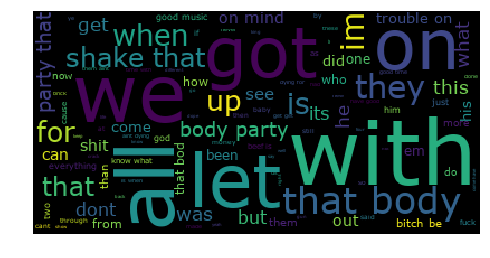

In [247]:
generate_wordcloud(push_words)

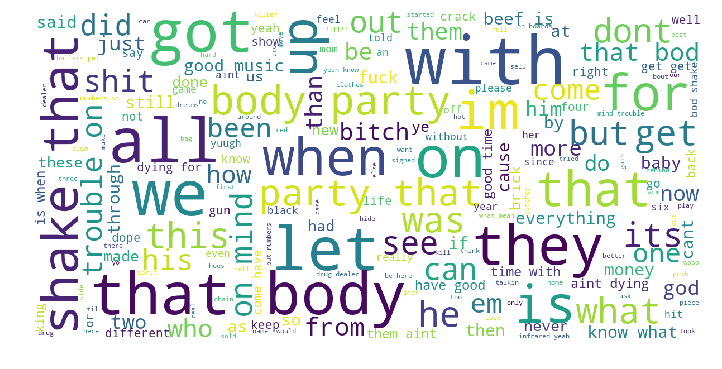

In [252]:
from wordcloud import WordCloud# , STOPWORDS
import matplotlib.pyplot as plt
#stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        #stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1, # chosen at random by flipping a coin; it was heads
        stopwords = {'to', 'of', 'nigga', 'the','you','and','it', 'your', 'my',
                     'in', 'me', 'like','niggas'}
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(push_words)

### Term Freq and IDF

In [259]:
def term_frequency(BoW_dict):
    total_terms = sum(BoW_dict.values())
    
    for word, count in BoW_dict.items():
        BoW_dict[word] = count / total_terms
    
    return BoW_dict

1802

In [260]:
test = term_frequency(earl_ctv)
test

{'teeth': 0.0005762581636573086,
 'wrong': 0.0001920860545524362,
 'ambulance': 0.0001920860545524362,
 'meaning': 0.0001920860545524362,
 'booty': 0.0001920860545524362,
 'freckled': 0.0001920860545524362,
 'stealin': 0.0001920860545524362,
 'dark': 0.0003841721091048724,
 'dollars': 0.0001920860545524362,
 'looking': 0.0001920860545524362,
 'gorditas': 0.0001920860545524362,
 'fishy': 0.0003841721091048724,
 'slightly': 0.0001920860545524362,
 'ish': 0.0001920860545524362,
 'eye': 0.0003841721091048724,
 'dead': 0.0001920860545524362,
 'kelly': 0.0001920860545524362,
 'pop': 0.0005762581636573086,
 'harmful': 0.0001920860545524362,
 'whisky': 0.0001920860545524362,
 'schindler': 0.0001920860545524362,
 'poop': 0.0001920860545524362,
 'purple': 0.0001920860545524362,
 'popping': 0.0001920860545524362,
 'jumped': 0.0001920860545524362,
 'full': 0.0005762581636573086,
 'curbs': 0.0001920860545524362,
 'check': 0.0001920860545524362,
 'shop': 0.0001920860545524362,
 'missed': 0.000192086

In [256]:
def inverse_document_frequency(list_of_dicts):
    vocab_set = set()
    
    # Iterate through list of dfs and add index to vocab_set
    for d in list_of_dicts:
        for word in d.keys():
            vocab_set.add(word)
    
    # Once vocab set is complete, create an empty dictionary with a key for each word and value of 0.      
    full_vocab_dict = {i:0 for i in vocab_set}
    
    # Loop through each word in full_vocab_dict
    for word, count in full_vocab_dict.items():
        docs = 0
    
        # Loop through list of dicts.  Each time a dictionary contains the word, increment docs by 1
        for d in list_of_dicts:
            if word in d:
                docs+=1
    
        # Now that we know denominator for equation, compute and set IDF value for word
        full_vocab_dict[word] = np.log(len(list_of_dicts)/float(docs))
    
    return full_vocab_dict

In [279]:
inverse_document_frequency(all_ctv)

{'teeth': 0.9162907318741551,
 'ambulance': 1.6094379124341003,
 'nutsacks': 2.302585092994046,
 'meaning': 0.9162907318741551,
 'tops': 2.302585092994046,
 'noodle': 2.302585092994046,
 'company': 2.302585092994046,
 'eh': 2.302585092994046,
 'scooped': 2.302585092994046,
 'loved': 1.6094379124341003,
 'lent': 2.302585092994046,
 'fishy': 2.302585092994046,
 'andretti': 2.302585092994046,
 'dead': 0.10536051565782635,
 'influence': 2.302585092994046,
 'rome': 2.302585092994046,
 'whisky': 2.302585092994046,
 'curses': 2.302585092994046,
 'brick': 2.302585092994046,
 'sin': 0.9162907318741551,
 'radios': 2.302585092994046,
 'eaten': 2.302585092994046,
 'jumped': 1.6094379124341003,
 'batteries': 1.6094379124341003,
 'full': 0.10536051565782635,
 'shop': 1.6094379124341003,
 'den': 2.302585092994046,
 'heading': 2.302585092994046,
 'satisfied': 2.302585092994046,
 'ooo': 2.302585092994046,
 'swift': 1.6094379124341003,
 'imma': 0.6931471805599453,
 'say': 0.0,
 '96': 1.6094379124341003,

In [262]:
def tf_idf(list_of_dicts):
    # Create empty dictionary containing full vocabulary of entire corpus
    doc_tf_idf = {}
    idf = inverse_document_frequency(list_of_dicts)
    full_vocab_list = {i:0 for i in list(idf.keys())}
    
    # Create tf-idf list of dictionaries, containing a dictionary that will be updated for each document
    tf_idf_list_of_dicts = []
    
    # Now, compute tf and then use this to compute and set tf-idf values for each document
    for doc in list_of_dicts:
        term_freq = term_frequency(doc)
        for word in term_freq:
            doc_tf_idf[word] = term_freq[word]*idf[word]
        tf_idf_list_of_dicts.append(doc_tf_idf)    
        
    return tf_idf_list_of_dicts

In [282]:
tf_idf_all_docs = tf_idf(all_ctv)
tf_idf_all_docs

[{'teeth': 0.00014684146344137174,
  'wrong': 0.00010661334447428589,
  'racism': 0.00020416566185894902,
  'stealin': 0.00030915057864657446,
  'looking': 0.00029070900904233383,
  'jeans': 0.00037904802459587676,
  'dead': 0.00015746602250459374,
  'wherever': 0.0006766338798101975,
  'rome': 0.0006766338798101975,
  'happenin': 0.00020416566185894902,
  'dial': 0.00040833132371789803,
  '300': 0.0023682185793356906,
  'check': 0.0005038912720147002,
  'plane': 0.00020416566185894902,
  'all': 0.0,
  'satisfied': 0.00033831693990509876,
  'intro': 0.00033831693990509876,
  'say': 0.0,
  'clack': 0.00031731820040105087,
  'bogus': 0.00033831693990509876,
  'wild': 0.00025619760432661696,
  'lonely': 0.0006808112996760176,
  'boucher': 0.00033831693990509876,
  'youd': 0.00017993914277774712,
  'sayin': 0.00012809880216330848,
  'lie': 0.0003570708959639209,
  'veins': 0.00033831693990509876,
  'what': 0.0,
  'sing': 7.634518364459392e-05,
  'summertime': 0.00033831693990509876,
  'chr

### Visualizing Vectorizations

In [277]:
num_dims = len(tf_idf_all_docs[0])
print("Number of Dimensions: {}".format(num_dims))

Number of Dimensions: 7148


### Reducing Dimensionality

In [281]:
tf_idf_vals_list = []

for i in tf_idf_all_docs:
    tf_idf_vals_list.append(list(i.values()))
    
tf_idf_vals_list[0][:10]

[0.00014684146344137174,
 0.00010661334447428589,
 0.00020416566185894902,
 0.00030915057864657446,
 0.00029070900904233383,
 0.00037904802459587687,
 0.00015746602250459374,
 0.0006766338798101793,
 0.0006766338798101793,
 0.00020416566185894902]

In [335]:
##3d
t_sne_object_3d = TSNE(n_components=3)
transformed_data_3d = t_sne_object_3d.fit_transform(tf_idf_vals_list)
transformed_data_3d

array([[ 523.2567  , -265.83258 , -143.33994 ],
       [  12.784625, -278.84    , -228.55484 ],
       [ 324.79095 ,   33.249954, -503.61667 ],
       [ 200.9508  ,  668.3784  , -137.08115 ],
       [-421.88586 , -203.41151 , -445.9673  ],
       [-125.081955,  499.87247 , 1053.0952  ],
       [ -76.35227 ,   31.765121,  337.713   ],
       [-484.20584 , -165.1425  ,  145.90045 ],
       [ 110.582985,  168.40974 ,  -61.163345],
       [-449.77298 ,  339.4284  ,   24.401188]], dtype=float32)

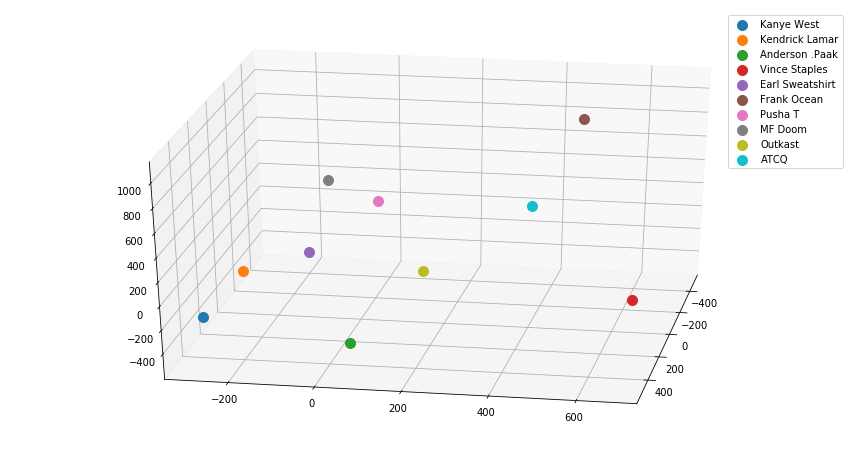

In [337]:
kanye_3d = transformed_data_3d[0]
ye3_x = kanye_3d[0]
ye3_y = kanye_3d[1]
ye3_z = kanye_3d[2]

kendrick_3d = transformed_data_3d[1]
k3_x = kendrick_3d[0]
k3_y = kendrick_3d[1]
k3_z = kendrick_3d[2]

paak_3d = transformed_data_3d[2]
p3_x = paak_3d[0]
p3_y = paak_3d[1]
p3_z = paak_3d[2]

vince_3d = transformed_data_3d[3]
v3_x = vince_3d[0]
v3_y = vince_3d[1]
v3_z = vince_3d[2]

earl_3d = transformed_data_3d[4]
e3_x = earl_3d[0]
e3_y = earl_3d[1]
e3_z = earl_3d[2]

frank_3d = transformed_data_3d[5]
f3_x = frank_3d[0]
f3_y = frank_3d[1]
f3_z = frank_3d[2]

pusha_3d = transformed_data_3d[6]
push3_x = pusha_3d[0]
push3_y = pusha_3d[1]
push3_z = pusha_3d[2]

doom_3d = transformed_data_3d[7]
doom3_x = doom_3d[0]
doom3_y = doom_3d[1]
doom3_z = doom_3d[2]

outkast_3d = transformed_data_3d[8]
o3_x = outkast_3d[0]
o3_y = outkast_3d[1]
o3_z = outkast_3d[2]

tribe_3d = transformed_data_3d[9]
t3_x = tribe_3d[0]
t3_y = tribe_3d[1]
t3_z = tribe_3d[2]



fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ye3_x, ye3_y, ye3_z, s=100, label='Kanye West')
ax.scatter(k3_x, k3_y, k3_z, s=100, label='Kendrick Lamar')
ax.scatter(p3_x, p3_y, p3_z, s=100, label='Anderson .Paak')
ax.scatter(v3_x, v3_y, v3_z, s=100, label='Vince Staples')
ax.scatter(e3_x, e3_y, e3_z, s=100, label='Earl Sweatshirt')
ax.scatter(f3_x, f3_y, f3_z, s=100, label='Frank Ocean')
ax.scatter(push3_x, push3_y, push3_z, s=100, label='Pusha T')
ax.scatter(doom3_x, doom3_y, doom3_z, s=100, label='MF Doom')
ax.scatter(o3_x, o3_y, o3_z, s=100, label='Outkast')
ax.scatter(t3_x, t3_y, t3_z, s=100, label='ATCQ')
ax.view_init(30, 10)
ax.legend()
plt.show()


In [352]:
all_songs = [kanye_songs,kendrick_songs,paak_songs,vince_songs,earl_songs,
frank_songs,pusha_songs,doom_songs,outkast_songs,tribe_songs]

In [355]:
ctv2 = []
for artist in all_songs:
    ctv2.extend([clean_token_and_vectorize_song(song) for song in artist])

In [363]:
tf_idf_all_songs = tf_idf(ctv2)
tf_idf_all_songs

[{'teeth': 0.0035567771387611394,
  'jerk': 0.004512944526795333,
  'cut': 0.0018000550729696382,
  'niggas': 0.0028427385332953936,
  'rhymin': 0.003904214576275592,
  'believe': 0.002644711704375941,
  'finally': 0.004297564519183165,
  'counts': 0.0041264965824265865,
  'whole': 0.001427767423300604,
  'mournin': 0.020632482912132932,
  'top': 0.0021935462239685757,
  'go': 0.0011783751413287043,
  '2': 0.005295028604419818,
  'neck': 0.0068213756619033275,
  'drunk': 0.0034646483461018745,
  'chain': 0.004640942472832093,
  'long': 0.002136401730000225,
  'cause': 0.00292802895853731,
  'let': 0.0025169503797919826,
  'hate': 0.003479845763491749,
  'exorcist': 0.0041264965824265865,
  'you': 0.00027137965053384433,
  'louis': 0.006107923766353304,
  'take': 0.0034769945798462615,
  'who': 0.0024506882151338286,
  'every': 0.013984274406005354,
  'well': 0.0013142263935275325,
  'wherever': 0.008252993164853173,
  'tour': 0.027493553349182714,
  'californicatin': 0.0041264965824265

In [364]:
num_dims = len(tf_idf_all_songs[0])
print("Number of Dimensions: {}".format(num_dims))

Number of Dimensions: 7148


In [365]:
tf_idf_vals_list2 = []

for i in tf_idf_all_songs:
    tf_idf_vals_list2.append(list(i.values()))
    
tf_idf_vals_list2[0][:10]

[0.0035567771387611394,
 0.004512944526795333,
 0.0018000550729696382,
 0.0028427385332953936,
 0.003904214576275592,
 0.002644711704375941,
 0.004297564519183165,
 0.0041264965824265865,
 0.001427767423300604,
 0.020632482912132932]

In [370]:
##3d
t_sne_object_3d = TSNE(n_components=3)
transformed_data_3d = t_sne_object_3d.fit_transform(tf_idf_vals_list2)
transformed_data_3d

/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/base.py:371: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(dist[sample_range, neigh_ind]), neigh_ind


array([[ -41.03657   ,   44.378513  ,  181.88318   ],
       [  89.00416   ,  152.34601   ,  114.51235   ],
       [ 160.9825    ,  -84.65379   ,   -9.000912  ],
       [ -88.82976   ,   85.2869    , -132.55139   ],
       [ 100.33828   ,   81.79978   ,  -85.78562   ],
       [  14.183644  ,   34.025204  ,  113.16271   ],
       [-133.6718    ,  127.02063   ,  -50.587086  ],
       [ 151.4749    ,   28.386885  ,   23.107552  ],
       [  97.90487   , -180.70161   ,   14.785533  ],
       [ 171.8811    ,  -47.917545  ,  -85.35985   ],
       [  30.616575  ,   89.57617   ,  -46.10716   ],
       [ -14.392634  ,  -80.73614   ,   74.81066   ],
       [-148.39746   ,  -71.050705  ,  -98.6466    ],
       [ 166.12505   ,   44.256252  ,  101.98229   ],
       [-127.01052   ,  -85.37242   ,   34.942764  ],
       [  55.134136  ,  -94.006386  ,  104.861855  ],
       [ -33.243477  ,   78.632324  ,   70.54667   ],
       [ -89.26444   ,  -31.754644  ,  176.56549   ],
       [ 111.531204  ,    3.

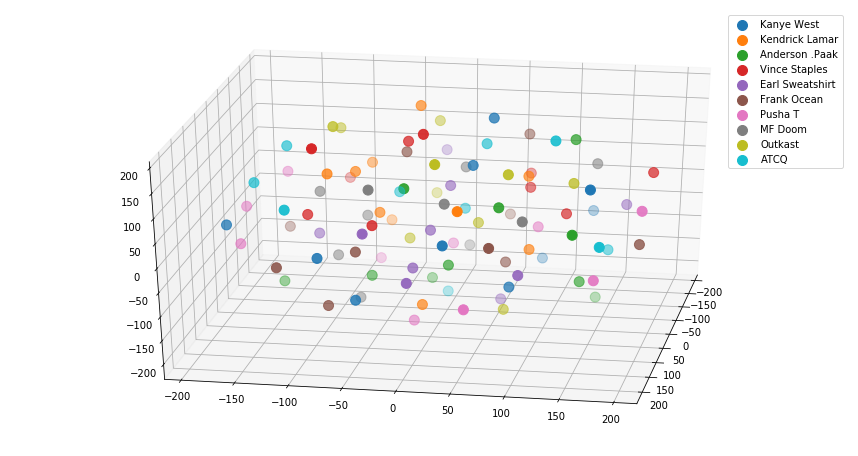

In [371]:
kanye_3d = transformed_data_3d[:10]
ye3_x = [i[0] for i in kanye_3d]
ye3_y = [i[1] for i in kanye_3d]
ye3_z = [i[2] for i in kanye_3d]

kendrick_3d = transformed_data_3d[10:20]
k3_x = [i[0] for i in kendrick_3d]
k3_y = [i[1] for i in kendrick_3d]
k3_z = [i[2] for i in kendrick_3d]

paak_3d = transformed_data_3d[20:30]
p3_x = [i[0] for i in paak_3d]
p3_y = [i[1] for i in paak_3d]
p3_z = [i[2] for i in paak_3d]

vince_3d = transformed_data_3d[30:40]
v3_x = [i[0] for i in vince_3d]
v3_y = [i[1] for i in vince_3d]
v3_z = [i[2] for i in vince_3d]

earl_3d = transformed_data_3d[40:50]
e3_x = [i[0] for i in earl_3d]
e3_y = [i[1] for i in earl_3d]
e3_z = [i[2] for i in earl_3d]

frank_3d = transformed_data_3d[50:60]
f3_x = [i[0] for i in frank_3d]
f3_y = [i[1] for i in frank_3d]
f3_z = [i[2] for i in frank_3d]

pusha_3d = transformed_data_3d[60:70]
push3_x = [i[0] for i in pusha_3d]
push3_y = [i[1] for i in pusha_3d]
push3_z = [i[2] for i in pusha_3d]

doom_3d = transformed_data_3d[70:80]
doom3_x = [i[0] for i in doom_3d]
doom3_y = [i[1] for i in doom_3d]
doom3_z = [i[2] for i in doom_3d]

outkast_3d = transformed_data_3d[80:90]
o3_x = [i[0] for i in outkast_3d]
o3_y = [i[1] for i in outkast_3d]
o3_z = [i[2] for i in outkast_3d]

tribe_3d = transformed_data_3d[90:]
t3_x = [i[0] for i in tribe_3d]
t3_y = [i[1] for i in tribe_3d]
t3_z = [i[2] for i in tribe_3d]


fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ye3_x, ye3_y, ye3_z, s=100, label='Kanye West')
ax.scatter(k3_x, k3_y, k3_z, s=100, label='Kendrick Lamar')
ax.scatter(p3_x, p3_y, p3_z, s=100, label='Anderson .Paak')
ax.scatter(v3_x, v3_y, v3_z, s=100, label='Vince Staples')
ax.scatter(e3_x, e3_y, e3_z, s=100, label='Earl Sweatshirt')
ax.scatter(f3_x, f3_y, f3_z, s=100, label='Frank Ocean')
ax.scatter(push3_x, push3_y, push3_z, s=100, label='Pusha T')
ax.scatter(doom3_x, doom3_y, doom3_z, s=100, label='MF Doom')
ax.scatter(o3_x, o3_y, o3_z, s=100, label='Outkast')
ax.scatter(t3_x, t3_y, t3_z, s=100, label='ATCQ')
ax.view_init(30, 10)
ax.legend()
plt.show()




In [384]:
import plotly.plotly as py
import plotly.graph_objs as go

import numpy as np

x, y, z = ye3_x, ye3_y, ye3_z
trace1 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    name='Kanye West',
    mode='markers',
    marker=dict(
        size=8,
        line=dict(
            color='rgba(217, 217, 217, 0.14)',
            width=0.5
        ),
        opacity=0.8
    )
)
x2, y2, z2 = k3_x,k3_y,k3_z
trace2 = go.Scatter3d(
    x=x2,
    y=y2,
    z=z2,
    mode='markers',
    name='Kendrick Lamar',
    marker=dict(
        size=8,
        symbol='circle',
        line=dict(
            color='rgb(204, 204, 204)',
            width=1
        ),
        opacity=0.9
    )
)
x3, y3, z3 = p3_x,p3_y,p3_z
trace3 = go.Scatter3d(
    x=x3,
    y=y3,
    z=z3,
    mode='markers',
    name='Anderson .Paak',
    marker=dict(
        size=8,
        symbol='circle',
        line=dict(
            color='rgb(204, 204, 204)',
            width=1
        ),
        opacity=0.9
    )
)
x4, y4, z4 = v3_x,v3_y,v3_z
trace4 = go.Scatter3d(
    x=x4,
    y=y4,
    z=z4,
    mode='markers',
    name='Vince Staples',
    marker=dict(
        size=8,
        symbol='circle',
        line=dict(
            color='rgb(204, 204, 204)',
            width=1
        ),
        opacity=0.9
    )
)
x5, y5, z5 = e3_x,e3_y,e3_z
trace5 = go.Scatter3d(
    x=x5,
    y=y5,
    z=z5,
    mode='markers',
    name='Earl Sweatshirt',
    marker=dict(
        size=8,
        symbol='circle',
        line=dict(
            color='rgb(204, 204, 204)',
            width=1
        ),
        opacity=0.9
    )
)
x6, y6, z6 = f3_x,f3_y,f3_z
trace6 = go.Scatter3d(
    x=x6,
    y=y6,
    z=z6,
    mode='markers',
    name='Frank Ocean',
    marker=dict(
        size=8,
        symbol='circle',
        line=dict(
            color='rgb(204, 204, 204)',
            width=1
        ),
        opacity=0.9
    )
)
x7, y7, z7 = push3_x,push3_y,push3_z
trace7 = go.Scatter3d(
    x=x7,
    y=y7,
    z=z7,
    mode='markers',
    name='Pusha T',
    marker=dict(
        size=8,
        symbol='circle',
        line=dict(
            color='rgb(204, 204, 204)',
            width=1
        ),
        opacity=0.9
    )
)
x8, y8, z8 = doom3_x,doom3_y,doom3_z
trace8 = go.Scatter3d(
    x=x8,
    y=y8,
    z=z8,
    mode='markers',
    name='MF Doom',
    marker=dict(
        size=8,
        symbol='circle',
        line=dict(
            color='rgb(204, 204, 204)',
            width=1
        ),
        opacity=0.9
    )
)
x9, y9, z9 = o3_x,o3_y,o3_z
trace9 = go.Scatter3d(
    x=x9,
    y=y9,
    z=z9,
    mode='markers',
    name='Outkast',
    marker=dict(
        size=8,
        symbol='circle',
        line=dict(
            color='rgb(204, 204, 204)',
            width=1
        ),
        opacity=0.9
    )
)
 

In [385]:

data = [trace1, trace2, trace3,trace4,trace5,trace6,trace7,trace8,trace9,trace10]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')